On rajoute les données meteo

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from matplotlib import cm
from matplotlib.colors import ListedColormap

from sklearn.preprocessing import SplineTransformer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import GammaRegressor
from sklearn import linear_model

In [2]:
stations_debit = pd.read_csv("../Data/Base/Stations_Debit.csv")
liste_stations_debit = list(stations_debit["Code station"])

mesures_train_X = pd.read_csv("../Data/Base/Mesures_Train_X.csv")
mesures_train_X["Date"] = pd.to_datetime(mesures_train_X["Date"], format = "%Y/%m/%d %H:%M:%S")
mesures_train_Y = pd.read_csv("../Data/Base/Mesures_Train_Y.csv")
mesures_train_Y["Date"] = pd.to_datetime(mesures_train_Y["Date"], format = "%Y/%m/%d %H:%M:%S")

train_split_X = pd.read_csv("../Data/Base/Index_CV_X.csv")
train_split_Y = pd.read_csv("../Data/Base/Index_CV_Y.csv")

mesures_test_X = pd.read_csv("../Data/Base/Mesures_Test_X.csv")
mesures_test_X["Date"] = pd.to_datetime(mesures_test_X["Date"], format = "%Y/%m/%d %H:%M:%S")
mesures_test_Y = pd.read_csv("../Data/Base/Mesures_Test_Y.csv")
mesures_test_Y["Date"] = pd.to_datetime(mesures_test_Y["Date"], format = "%Y/%m/%d %H:%M:%S")

In [3]:
stations_meteo = pd.read_csv("../Data/Base/Stations_Meteo.csv")
liste_stations_meteo = list(stations_meteo["ID"].apply(lambda x: str(x).rjust(5, "0")))
colonnes_meteo = ["Pression", "Vent_Nord", "Vent_Est", "Vitesse_vent", "Temperature", "Humidite", "Precipitations"]
tempo = []
for code in liste_stations_meteo:
    tempo += [tp + "_" + code for tp in colonnes_meteo]
colonnes_meteo_stations = tempo

In [4]:
%run Eval_fcts.py
%run Standardize_fcts.py

# Fonctions Lasso

# Val croisée

In [82]:
lasso_grid = [1, 3, 10, 30, 100, 300, 1000]

In [83]:
n_knots = 10

for curr_alpha in tqdm(lasso_grid):
    cv_scores_RMSE_standard = pd.DataFrame({"Code station": liste_stations_debit})
    cv_scores_MAE_standard = pd.DataFrame({"Code station": liste_stations_debit})
    cv_scores_R2_standard = pd.DataFrame({"Code station": liste_stations_debit})
    
    cv_scores_RMSE = pd.DataFrame({"Code station": liste_stations_debit})
    cv_scores_MAE = pd.DataFrame({"Code station": liste_stations_debit})
    cv_scores_R2 = pd.DataFrame({"Code station": liste_stations_debit})
    
    for curr_split in range(9):
        
        # Entraintement
        curr_train_X = mesures_train_X[train_split_X["Train_" + str(curr_split)]]
        curr_train_Y = mesures_train_Y[train_split_Y["Train_" + str(curr_split)]]
        
        curr_train_X_mean = curr_train_X[liste_stations_debit + colonnes_meteo_stations].mean()
        curr_train_X_std = curr_train_X[liste_stations_debit + colonnes_meteo_stations].std()
        curr_train_X_standard = fct_Standardize(curr_train_X, curr_train_X_mean,
                                                curr_train_X_std, liste_stations_debit + colonnes_meteo_stations)
        curr_train_X_standard["Date"] = curr_train_X["Date"]
        model = linear_model.Lasso(alpha = curr_alpha/1000, max_iter = 20000)
        model.fit(X = curr_train_X_standard[colonnes_meteo_stations],
                  y = curr_train_X_standard[liste_stations_debit])
        
        # Predictions Standard
        curr_test_X = mesures_train_X[train_split_X["Test_" + str(curr_split)]]
        curr_test_Y = mesures_train_Y[train_split_Y["Test_" + str(curr_split)]]
        liste_dates = curr_test_Y["Date"]
        curr_test_X_standard =fct_Standardize(curr_test_X, curr_train_X_mean,
                                              curr_train_X_std, liste_stations_debit + colonnes_meteo_stations)
        curr_test_X_standard["Date"] = curr_test_X["Date"].values
        predictions_Y_standard = model.predict(curr_test_X_standard[colonnes_meteo_stations])
        predictions_Y_standard = pd.DataFrame(predictions_Y_standard, columns=liste_stations_debit)
        predictions_Y_standard["Date"] = curr_test_X_standard["Date"].values
        # Filtre sur les dates
        resultat = pd.DataFrame()
        for curr_date in liste_dates:
            resultat = pd.concat([resultat, predictions_Y_standard[predictions_Y_standard["Date"] == curr_date]])
        resultat = resultat.sort_values(by = "Date")
        predictions_Y_standard = resultat.copy()
        
        # Score standard
        curr_test_Y_standard = fct_Standardize(curr_test_Y, curr_train_X_mean,
                                                curr_train_X_std, liste_stations_debit)
        curr_test_Y_standard["Date"] = curr_test_Y["Date"]
        curr_RMSE = fct_RMSE(curr_test_Y_standard, predictions_Y_standard, liste_stations_debit)
        cv_scores_RMSE_standard["Split_" + str(curr_split)] = curr_RMSE["RMSE"]
        curr_MAE = fct_MAE(curr_test_Y_standard, predictions_Y_standard, liste_stations_debit)
        cv_scores_MAE_standard["Split_" + str(curr_split)] = curr_MAE["MAE"]
        curr_R2 = fct_R2(curr_test_Y_standard, predictions_Y_standard, liste_stations_debit)
        cv_scores_R2_standard["Split_" + str(curr_split)] = curr_R2["R2"]
        
        # Score
        predictions_Y = fct_StandardizeInverse(predictions_Y_standard, curr_train_X_mean,
                                              curr_train_X_std, liste_stations_debit)
        predictions_Y["Date"] = predictions_Y_standard["Date"].values
        curr_RMSE = fct_RMSE(curr_test_Y, predictions_Y, liste_stations_debit)
        cv_scores_RMSE["Split_" + str(curr_split)] = curr_RMSE["RMSE"]
        curr_MAE = fct_MAE(curr_test_Y, predictions_Y, liste_stations_debit)
        cv_scores_MAE["Split_" + str(curr_split)] = curr_MAE["MAE"]
        curr_R2 = fct_R2(curr_test_Y, predictions_Y, liste_stations_debit)
        cv_scores_R2["Split_" + str(curr_split)] = curr_R2["R2"]
    
    cv_moyen_RMSE_standard = []
    cv_moyen_MAE_standard = []
    cv_moyen_R2_standard = []
    
    cv_moyen_RMSE = []
    cv_moyen_MAE = []
    cv_moyen_R2 = []

    for code in liste_stations_debit:
        score_RMSE = np.mean(cv_scores_RMSE_standard[cv_scores_RMSE_standard["Code station"] == code][["Split_" + str(i) for i in range(9)]].iloc[0,:])
        cv_moyen_RMSE_standard.append(score_RMSE)
        score_MAE = np.mean(cv_scores_MAE_standard[cv_scores_MAE_standard["Code station"] == code][["Split_" + str(i) for i in range(9)]].iloc[0,:])
        cv_moyen_MAE_standard.append(score_MAE)
        score_R2 = np.mean(cv_scores_R2_standard[cv_scores_R2_standard["Code station"] == code][["Split_" + str(i) for i in range(9)]].iloc[0,:])
        cv_moyen_R2_standard.append(score_R2)
        score_RMSE = np.mean(cv_scores_RMSE[cv_scores_RMSE["Code station"] == code][["Split_" + str(i) for i in range(9)]].iloc[0,:])
        cv_moyen_RMSE.append(score_RMSE)
        score_MAE = np.mean(cv_scores_MAE[cv_scores_MAE["Code station"] == code][["Split_" + str(i) for i in range(9)]].iloc[0,:])
        cv_moyen_MAE.append(score_MAE)
        score_R2 = np.mean(cv_scores_R2[cv_scores_R2["Code station"] == code][["Split_" + str(i) for i in range(9)]].iloc[0,:])
        cv_moyen_R2.append(score_R2)

    cv_scores_RMSE_standard["Moyenne"] = cv_moyen_RMSE_standard
    cv_scores_RMSE_standard.to_csv("../Data/LASSO_Meteo/CV_RMSE_standard_alpha_" + str(curr_alpha) + ".csv",
                          index=False)
    cv_scores_MAE_standard["Moyenne"] = cv_moyen_MAE_standard
    cv_scores_MAE_standard.to_csv("../Data/LASSO_Meteo/CV_MAE_standard_alpha_" + str(curr_alpha) + ".csv",
                          index=False)
    cv_scores_R2_standard["Moyenne"] = cv_moyen_R2_standard
    cv_scores_R2_standard.to_csv("../Data/LASSO_Meteo/CV_R2_standard_alpha_" + str(curr_alpha) + ".csv",
                          index=False)
    cv_scores_RMSE["Moyenne"] = cv_moyen_RMSE
    cv_scores_RMSE.to_csv("../Data/LASSO_Meteo/CV_RMSE_alpha_" + str(curr_alpha) + ".csv",
                          index=False)
    cv_scores_MAE["Moyenne"] = cv_moyen_MAE
    cv_scores_MAE.to_csv("../Data/LASSO_Meteo/CV_MAE_alpha_" + str(curr_alpha) + ".csv",
                          index=False)
    cv_scores_R2["Moyenne"] = cv_moyen_R2
    cv_scores_R2.to_csv("../Data/LASSO_Meteo/CV_R2_alpha_" + str(curr_alpha) + ".csv",
                          index=False)

100%|██████████| 7/7 [08:50<00:00, 75.77s/it] 


## Selection

In [84]:
n_cours_eau = 3
cours_eau = list(np.unique(stations_debit["Cours eau"]))
cours_eau_cmap = cm.get_cmap(ListedColormap(["red", "green", "blue"]))
cours_eau_couleur = pd.DataFrame({"Cours eau": cours_eau, "Index": range(n_cours_eau), "Couleur": ["red", "green", "blue"]})
cours_eau_couleur

,Cours eau,Index,Couleur
0,Garonne,0,red
1,Loire,1,green
2,Seine,2,blue


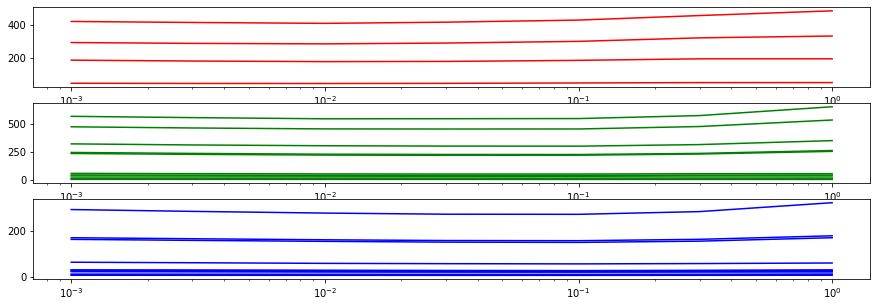

In [85]:
cv_moyen = pd.DataFrame()

for curr_alpha in lasso_grid:
    curr_moyen = {}
    cv_scores = pd.read_csv("../Data/LASSO_Meteo/CV_RMSE_alpha_" + str(curr_alpha) + ".csv")
    for code in liste_stations_debit:
        curr_moyen[code] = list(cv_scores[cv_scores["Code station"] == code]["Moyenne"])
    curr_moyen = pd.DataFrame(curr_moyen)
    curr_moyen["Alpha"] = curr_alpha/1000
    cv_moyen = pd.concat([cv_moyen, curr_moyen])

fig, axs = plt.subplots(n_cours_eau, 1, figsize = (15,5))
for i in range(n_cours_eau):
    stations = list(stations_debit[stations_debit["Cours eau"] == list(cours_eau_couleur[cours_eau_couleur["Index"] == i]["Cours eau"])[0]]["Code station"])
    for code in stations:
        axs[i].plot(cv_moyen["Alpha"], cv_moyen[code],
                   color = cours_eau_cmap(i))
        axs[i].set_xscale("log")
plt.show()

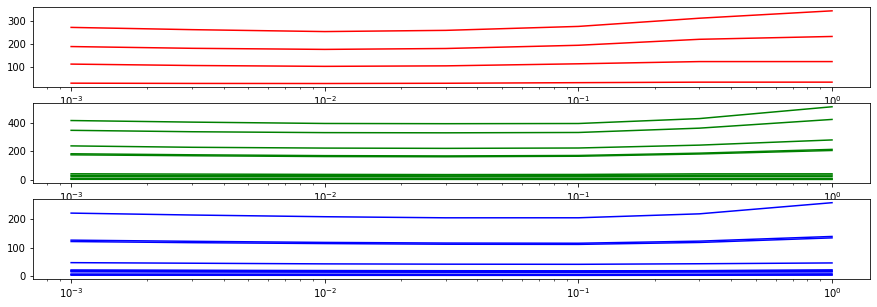

In [86]:
cv_moyen = pd.DataFrame()

for curr_alpha in lasso_grid:
    curr_moyen = {}
    cv_scores = pd.read_csv("../Data/LASSO_Meteo/CV_MAE_alpha_" + str(curr_alpha) + ".csv")
    for code in liste_stations_debit:
        curr_moyen[code] = list(cv_scores[cv_scores["Code station"] == code]["Moyenne"])
    curr_moyen = pd.DataFrame(curr_moyen)
    curr_moyen["Alpha"] = curr_alpha/1000
    cv_moyen = pd.concat([cv_moyen, curr_moyen])

fig, axs = plt.subplots(n_cours_eau, 1, figsize = (15,5))
for i in range(n_cours_eau):
    stations = list(stations_debit[stations_debit["Cours eau"] == list(cours_eau_couleur[cours_eau_couleur["Index"] == i]["Cours eau"])[0]]["Code station"])
    for code in stations:
        axs[i].plot(cv_moyen["Alpha"], cv_moyen[code],
                   color = cours_eau_cmap(i))
        axs[i].set_xscale("log")
plt.show()

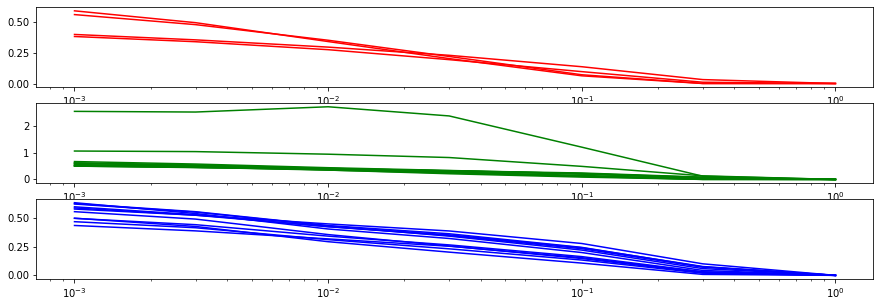

In [87]:
cv_moyen = pd.DataFrame()

for curr_alpha in lasso_grid:
    curr_moyen = {}
    cv_scores = pd.read_csv("../Data/LASSO_Meteo/CV_R2_alpha_" + str(curr_alpha) + ".csv")
    for code in liste_stations_debit:
        curr_moyen[code] = list(cv_scores[cv_scores["Code station"] == code]["Moyenne"])
    curr_moyen = pd.DataFrame(curr_moyen)
    curr_moyen["Alpha"] = curr_alpha/1000
    cv_moyen = pd.concat([cv_moyen, curr_moyen])

fig, axs = plt.subplots(n_cours_eau, 1, figsize = (15,5))
for i in range(n_cours_eau):
    stations = list(stations_debit[stations_debit["Cours eau"] == list(cours_eau_couleur[cours_eau_couleur["Index"] == i]["Cours eau"])[0]]["Code station"])
    for code in stations:
        axs[i].plot(cv_moyen["Alpha"], cv_moyen[code],
                   color = cours_eau_cmap(i))
        axs[i].set_xscale("log")
plt.show()

## Standard

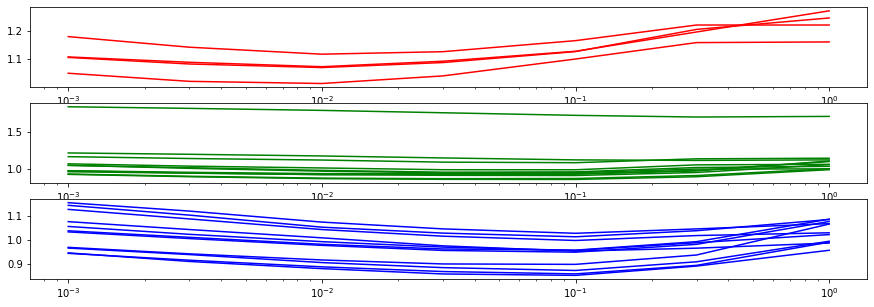

In [88]:
cv_moyen = pd.DataFrame()

for curr_alpha in lasso_grid:
    curr_moyen = {}
    cv_scores = pd.read_csv("../Data/LASSO_Meteo/CV_RMSE_standard_alpha_" + str(curr_alpha) + ".csv")
    for code in liste_stations_debit:
        curr_moyen[code] = list(cv_scores[cv_scores["Code station"] == code]["Moyenne"])
    curr_moyen = pd.DataFrame(curr_moyen)
    curr_moyen["Alpha"] = curr_alpha/1000
    cv_moyen = pd.concat([cv_moyen, curr_moyen])

fig, axs = plt.subplots(n_cours_eau, 1, figsize = (15,5))
for i in range(n_cours_eau):
    stations = list(stations_debit[stations_debit["Cours eau"] == list(cours_eau_couleur[cours_eau_couleur["Index"] == i]["Cours eau"])[0]]["Code station"])
    for code in stations:
        axs[i].plot(cv_moyen["Alpha"], cv_moyen[code],
                   color = cours_eau_cmap(i))
        axs[i].set_xscale("log")
plt.show()

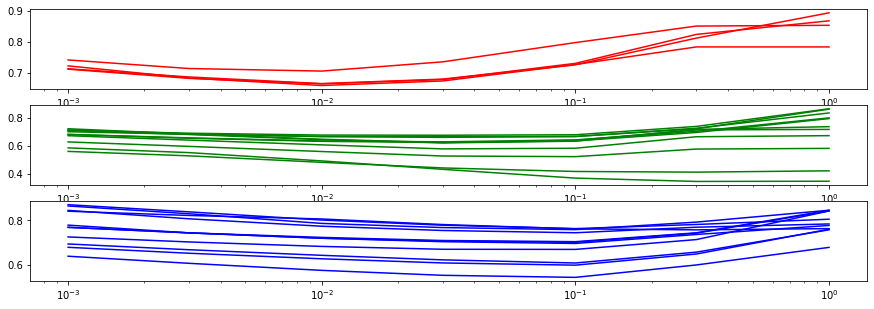

In [89]:
cv_moyen = pd.DataFrame()

for curr_alpha in lasso_grid:
    curr_moyen = {}
    cv_scores = pd.read_csv("../Data/LASSO_Meteo/CV_MAE_standard_alpha_" + str(curr_alpha) + ".csv")
    for code in liste_stations_debit:
        curr_moyen[code] = list(cv_scores[cv_scores["Code station"] == code]["Moyenne"])
    curr_moyen = pd.DataFrame(curr_moyen)
    curr_moyen["Alpha"] = curr_alpha/1000
    cv_moyen = pd.concat([cv_moyen, curr_moyen])

fig, axs = plt.subplots(n_cours_eau, 1, figsize = (15,5))
for i in range(n_cours_eau):
    stations = list(stations_debit[stations_debit["Cours eau"] == list(cours_eau_couleur[cours_eau_couleur["Index"] == i]["Cours eau"])[0]]["Code station"])
    for code in stations:
        axs[i].plot(cv_moyen["Alpha"], cv_moyen[code],
                   color = cours_eau_cmap(i))
        axs[i].set_xscale("log")
plt.show()

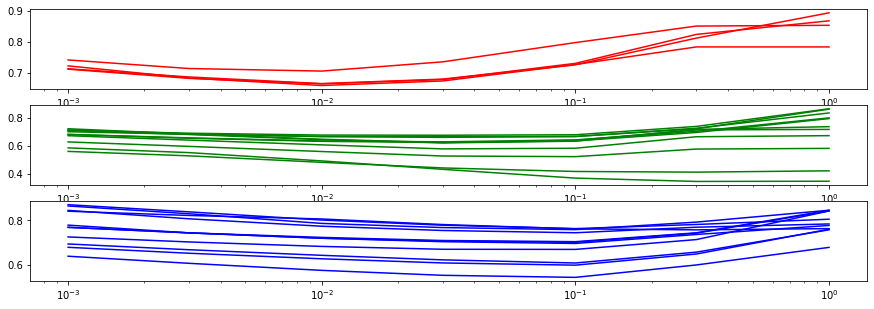

In [90]:
cv_moyen = pd.DataFrame()

for curr_alpha in lasso_grid:
    curr_moyen = {}
    cv_scores = pd.read_csv("../Data/LASSO_Meteo/CV_MAE_standard_alpha_" + str(curr_alpha) + ".csv")
    for code in liste_stations_debit:
        curr_moyen[code] = list(cv_scores[cv_scores["Code station"] == code]["Moyenne"])
    curr_moyen = pd.DataFrame(curr_moyen)
    curr_moyen["Alpha"] = curr_alpha/1000
    cv_moyen = pd.concat([cv_moyen, curr_moyen])

fig, axs = plt.subplots(n_cours_eau, 1, figsize = (15,5))
for i in range(n_cours_eau):
    stations = list(stations_debit[stations_debit["Cours eau"] == list(cours_eau_couleur[cours_eau_couleur["Index"] == i]["Cours eau"])[0]]["Code station"])
    for code in stations:
        axs[i].plot(cv_moyen["Alpha"], cv_moyen[code],
                   color = cours_eau_cmap(i))
        axs[i].set_xscale("log")
plt.show()

## Moyen

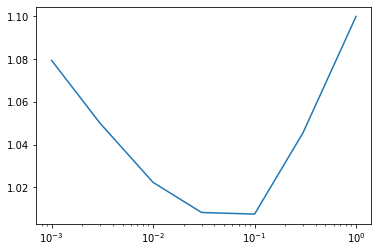

In [91]:
cv_moyen = pd.DataFrame()
for curr_alpha in lasso_grid:
    curr_moyen = {}
    cv_scores = pd.read_csv("../Data/LASSO_Meteo/CV_RMSE_standard_alpha_" + str(curr_alpha) + ".csv")
    for code in liste_stations_debit:
        curr_moyen[code] = list(cv_scores[cv_scores["Code station"] == code]["Moyenne"])
    curr_moyen = pd.DataFrame(curr_moyen)
    curr_moyen["Alpha"] = curr_alpha/1000
    cv_moyen = pd.concat([cv_moyen, curr_moyen])

plt.plot(cv_moyen["Alpha"], cv_moyen[liste_stations_debit].mean(axis = 1).values)
plt.xscale("log")

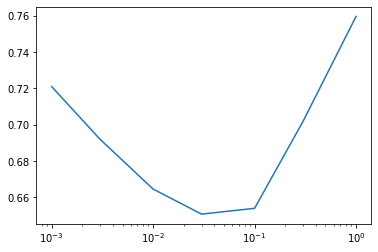

In [93]:
cv_moyen = pd.DataFrame()
for curr_alpha in lasso_grid:
    curr_moyen = {}
    cv_scores = pd.read_csv("../Data/LASSO_Meteo/CV_MAE_standard_alpha_" + str(curr_alpha) + ".csv")
    for code in liste_stations_debit:
        curr_moyen[code] = list(cv_scores[cv_scores["Code station"] == code]["Moyenne"])
    curr_moyen = pd.DataFrame(curr_moyen)
    curr_moyen["Alpha"] = curr_alpha/1000
    cv_moyen = pd.concat([cv_moyen, curr_moyen])

plt.plot(cv_moyen["Alpha"], cv_moyen[liste_stations_debit].mean(axis = 1).values)
plt.xscale("log")

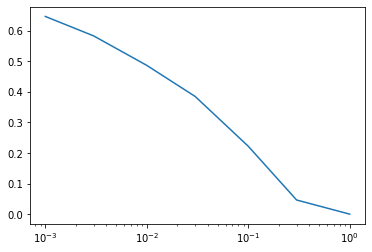

In [94]:
cv_moyen = pd.DataFrame()
for curr_alpha in lasso_grid:
    curr_moyen = {}
    cv_scores = pd.read_csv("../Data/LASSO_Meteo/CV_R2_standard_alpha_" + str(curr_alpha) + ".csv")
    for code in liste_stations_debit:
        curr_moyen[code] = list(cv_scores[cv_scores["Code station"] == code]["Moyenne"])
    curr_moyen = pd.DataFrame(curr_moyen)
    curr_moyen["Alpha"] = curr_alpha/1000
    cv_moyen = pd.concat([cv_moyen, curr_moyen])

plt.plot(cv_moyen["Alpha"], cv_moyen[liste_stations_debit].mean(axis = 1).values)
plt.xscale("log")

# Test

In [96]:
alpha = 0.03

In [97]:
# Entraintement
mesures_train_X_mean = mesures_train_X[liste_stations_debit + colonnes_meteo_stations].mean()
mesures_train_X_std = mesures_train_X[liste_stations_debit + colonnes_meteo_stations].std()
mesures_train_X_standard = fct_Standardize(mesures_train_X, 
                                           mesures_train_X_mean, mesures_train_X_std, 
                                           liste_stations_debit + colonnes_meteo_stations)
mesures_train_X_standard["Date"] = mesures_train_X["Date"]
model = linear_model.Lasso(alpha = alpha, max_iter = 20000)
model.fit(X = mesures_train_X_standard[colonnes_meteo_stations],
          y = mesures_train_X_standard[liste_stations_debit])

Lasso(alpha=0.03, max_iter=20000)

In [107]:
# Predictions Standard
liste_dates = mesures_test_Y["Date"]
mesures_test_X_standard =fct_Standardize(mesures_test_X, 
                                         mesures_train_X_mean, mesures_train_X_std, 
                                         liste_stations_debit + colonnes_meteo_stations)
mesures_test_X_standard["Date"] = mesures_test_X["Date"].values
predictions_test_Y_standard = model.predict(mesures_test_X_standard[colonnes_meteo_stations])
predictions_test_Y_standard = pd.DataFrame(predictions_test_Y_standard, columns=liste_stations_debit)
predictions_test_Y_standard["Date"] = mesures_test_X_standard["Date"].values

In [108]:
# Filtre sur les dates
resultat = pd.DataFrame()
for curr_date in liste_dates:
    resultat = pd.concat([resultat, predictions_test_Y_standard[predictions_test_Y_standard["Date"] == curr_date]])
resultat = resultat.sort_values(by = "Date")
predictions_test_Y_standard = resultat.copy()

In [109]:
mesures_test_Y_standard = fct_Standardize(mesures_test_Y,
                                          mesures_train_X_mean, mesures_train_X_std,
                                          liste_stations_debit)
mesures_test_Y_standard["Date"] = mesures_test_Y["Date"]

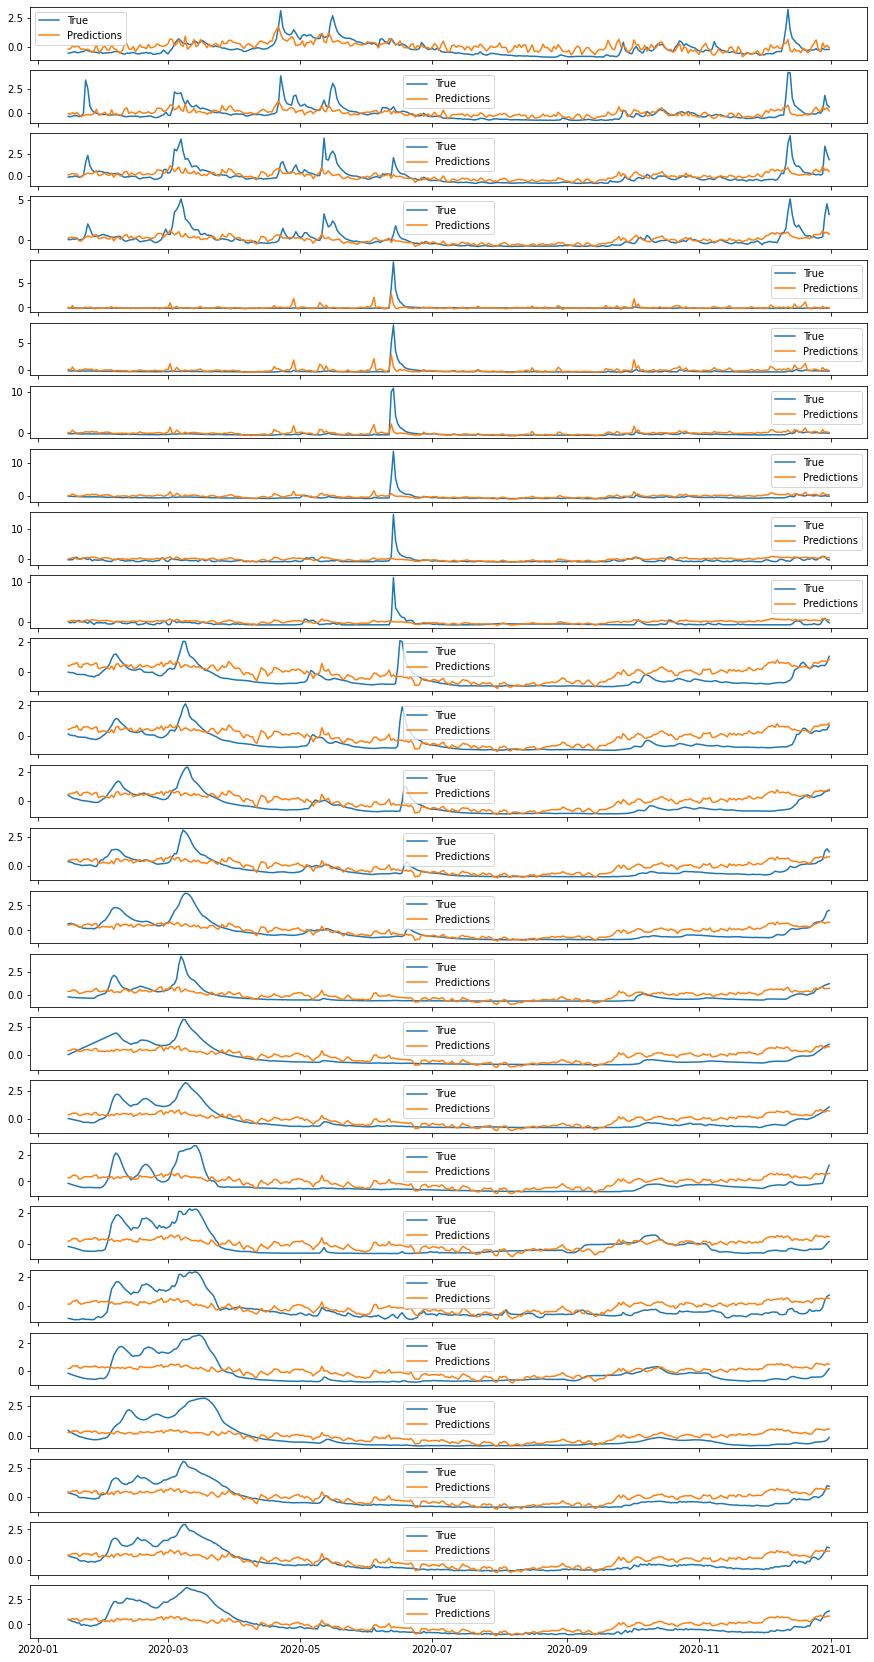

In [110]:
n_stations = len(liste_stations_debit)
fig, axs = plt.subplots(n_stations, 1, figsize = (15,30), sharex=True)
for i in range(n_stations):
    code = liste_stations_debit[i]
    axs[i].plot(mesures_test_Y_standard["Date"], mesures_test_Y_standard[code], label = "True")
    axs[i].plot(predictions_test_Y_standard["Date"], predictions_test_Y_standard[code], label = "Predictions")
    axs[i].legend()

In [113]:
scores_rmse_standard = fct_RMSE(mesures_test_Y_standard, predictions_test_Y_standard, liste_stations_debit)
scores_mae_standard = fct_MAE(mesures_test_Y_standard, predictions_test_Y_standard, liste_stations_debit)
scores_r2_standard = fct_R2(mesures_test_Y_standard, predictions_test_Y_standard, liste_stations_debit)

test_scores_standard = pd.DataFrame({"Code station": liste_stations_debit,
                            "RMSE": scores_rmse_standard["RMSE"],
                            "MAE": scores_mae_standard["MAE"],
                            "R2": scores_r2_standard["R2"]})
test_scores_standard

,Code station,RMSE,MAE,R2
0,O0200020,0.560907,0.441283,0.320444
1,O2620010,0.683741,0.451958,0.168422
2,O6140010,0.759091,0.492538,0.193764
3,O9000010,0.819540,0.494011,0.194569
4,K0030020,0.599157,0.192646,0.252887
5,K0100020,0.611817,0.296605,0.317045
6,K0260020,0.866354,0.393301,0.183300
7,K0550010,0.980507,0.518388,0.181452
8,K0690010,1.071789,0.594245,0.158256
9,K0910050,0.912946,0.585951,0.176637


In [114]:
test_scores_standard.to_csv("../Data/LASSO_Meteo/Test_scores_standard.csv",
                   index = False)

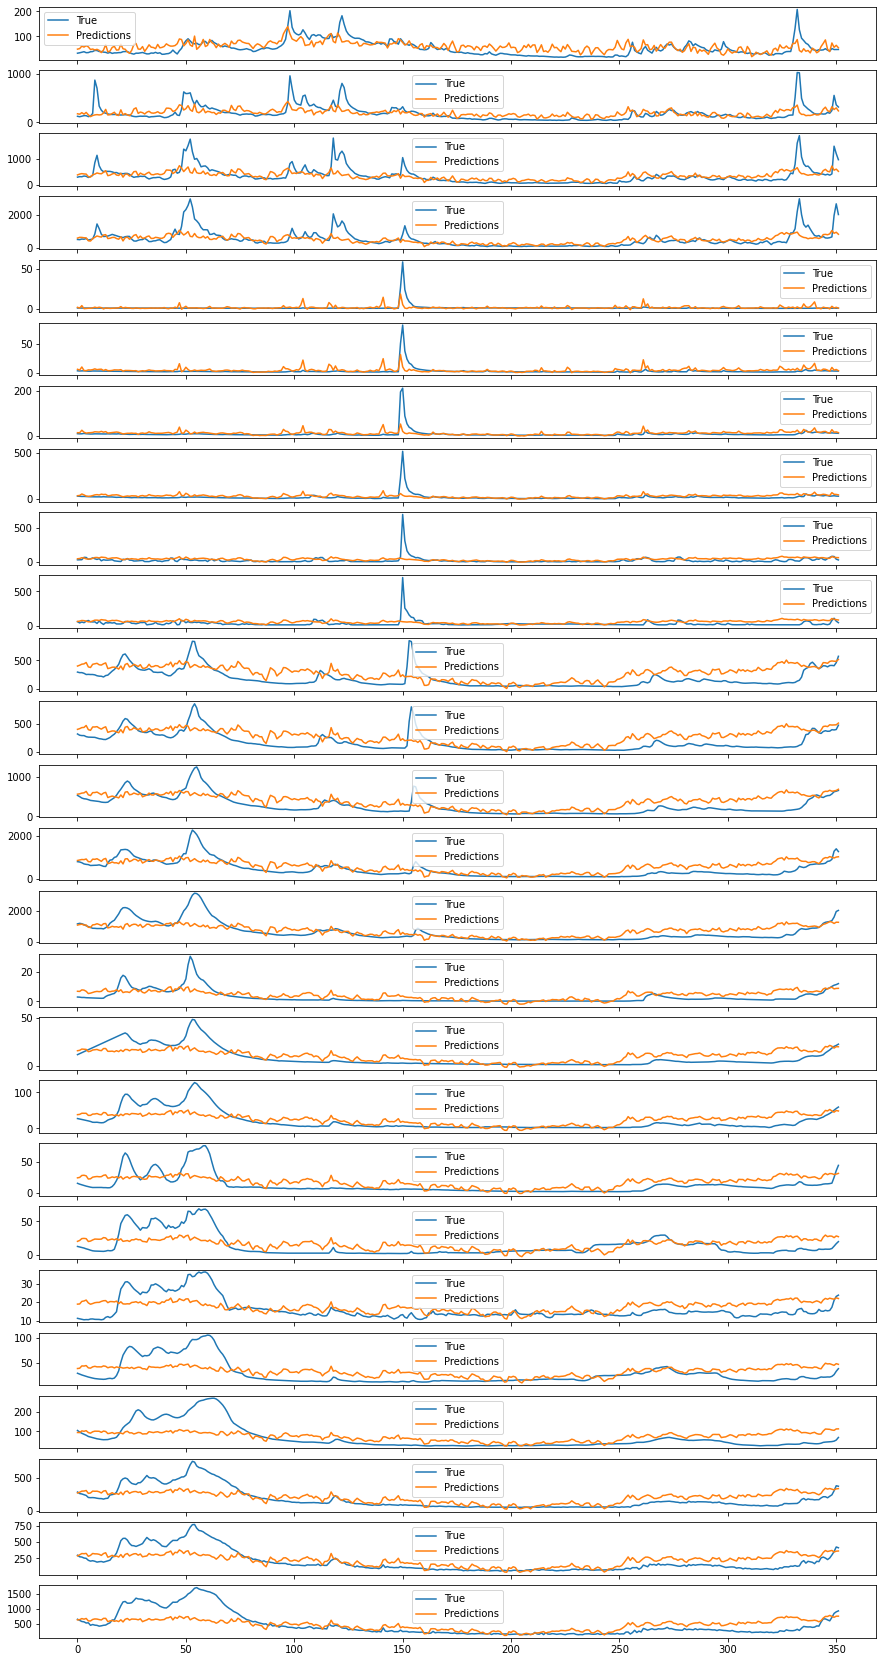

In [118]:
predictions_test_Y = fct_StandardizeInverse(predictions_test_Y_standard, mesures_train_X_mean,
                                              mesures_train_X_std, liste_stations_debit)
predictions_test_Y["Date"] = predictions_test_Y_standard["Date"].values

n_stations = len(liste_stations_debit)
fig, axs = plt.subplots(n_stations, 1, figsize = (15,30), sharex=True)
for i in range(n_stations):
    code = liste_stations_debit[i]
    axs[i].plot(mesures_test_Y[code], label = "True")
    axs[i].plot(predictions_test_Y[code], label = "Predictions")
    axs[i].legend()

In [120]:
scores_rmse = fct_RMSE(mesures_test_Y, predictions_test_Y, liste_stations_debit)
scores_mae = fct_MAE(mesures_test_Y, predictions_test_Y, liste_stations_debit)
scores_r2 = fct_R2(mesures_test_Y, predictions_test_Y, liste_stations_debit)

test_scores = pd.DataFrame({"Code station": liste_stations_debit,
                            "RMSE": scores_rmse["RMSE"],
                            "MAE": scores_mae["MAE"],
                            "R2": scores_r2["R2"]})
test_scores

,Code station,RMSE,MAE,R2
0,O0200020,26.038244,20.485094,0.320444
1,O2620010,135.527131,89.584383,0.168422
2,O6140010,249.772034,162.065229,0.193764
3,O9000010,398.472763,240.195441,0.194569
4,K0030020,3.674374,1.181419,0.252887
5,K0100020,5.760765,2.792782,0.317045
6,K0260020,16.048762,7.285695,0.183300
7,K0550010,35.722274,18.886147,0.181452
8,K0690010,47.948153,26.584475,0.158256
9,K0910050,52.715770,33.834289,0.176637


In [121]:
test_scores.to_csv("../Data/LASSO_Meteo/Test_scores.csv",
                   index = False)

In [130]:
np.sum(model.coef_ == 0, axis = 1)

array([207, 211, 213, 218, 227, 217, 221, 217, 219, 224, 226, 225, 226,
       228, 228, 226, 231, 228, 228, 228, 226, 229, 231, 230, 227, 226])